### DEMDP02 
# Asset Replacement Model

Profit-maximizing entrepreneur must decide when to replace an aging asset.

In [1]:
%matplotlib inline 
from warnings import simplefilter
simplefilter('ignore')
from compecon import BasisSpline, DPmodel
from compecon.quad import qnwnorm
from demos.setup import np, plt, demo


### Model Parameters

The maximum age of the asset is $A=6$,  production function coefficients are $\alpha =[50.0, -2.5, -2.5]$, net replacement cost is $\kappa = 40$, long-run mean unit profit is $\bar{p} = 1$, the unit profit autoregression coefficient is $\gamma = 0.5$, the standard deviation of unit profit shock is $\sigma = 0.15$, and the discount factor is $\delta = 0.9$.


In [2]:
A       = 6
alpha   = np.array([50, -2.5, -2.5])
kappa   = 40
pbar    = 1.0
gamma   = 0.5
sigma   = 0.15
delta   = 0.9

### State space
The state variables are the current unit profit $p$ (continuous) and the age of asset $a\in\{1,2,\dots,A\}$. 

Here, we approximate the unit profit with a cubic spline basis of $n=200$ nodes, over the interval $p\in[0,2]$.

In [3]:
n  = 200
pmin, pmax = 0.0, 2.0  
basis = BasisSpline(n, pmin, pmax, labels=['unit profit'])

### Action space
There is only one choice variable $j$: whether to keep(0) or replace(1) the asset.

### Reward Function
The instant profit depends on the asset age and whether it is replaced. An asset of age $a=A$ must be replaced. 
If the asset is replaced, the profit is $50p$ minus the cost of replacement $\kappa$; otherwise the profit depends on the age of the asset, $(\alpha_0 + \alpha_1 a + \alpha_2 a^2)p$.


In [4]:
def profit(p, x, i, j):
    a = i + 1
    if j or a == A:
        return p * 50 - kappa
    else:
        return p * (alpha[0] + alpha[1] * a + alpha[2] * a ** 2 )

### State Transition Function

The unit profit $p$ follows a Markov Process 
\begin{equation}p' = \bar{p} + \gamma(p-\bar{p}) + \epsilon \end{equation}
where $\epsilon \sim N(0,\sigma^2)$.

In [5]:
def transition(p, x, i, j, in_, e):
    return pbar + gamma * (p - pbar) + e

The continuous shock must be discretized. Here we use Gauss-Legendre quadrature to obtain nodes and weights defining a discrete distribution that matches the first 10 moments of the Normal distribution (this is achieved with $m=5$ nodes and weights).

In [6]:
m = 5
e, w = qnwnorm(m,0,sigma ** 2)

On the other hand, the age of the asset is deterministic: if it is replaced now it will be new ($a=0$) next period; otherwise its age will be $a+1$ next period if current age is $a$.

In [7]:
h = np.zeros((2, A))
h[0, :-1] = np.arange(1, A)

## Model Structure

In [8]:
model = DPmodel(basis, profit, transition,
                i=[a + 1 for a in range(A)],
                j=['keep', 'replace'],
                discount=delta, e=e, w=w, h=h)

### SOLUTION
The ```solve``` method returns a pandas ```DataFrame```.

In [9]:
S = model.solve()

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       3.7e+02    0.2287
   1       4.3e+01    0.5015
   2       1.2e+01    0.7568
   3       5.7e-01    0.9986
   4       4.9e-13    1.2563
Elapsed Time =    1.26 Seconds


## Analysis

### Plot Action-Contingent Value Functions

Critical Replacement Profit

   Age  1  Profit  1.50
   Age  2  Profit  0.66
   Age  3  Profit  0.38
   Age  4  Profit  0.25


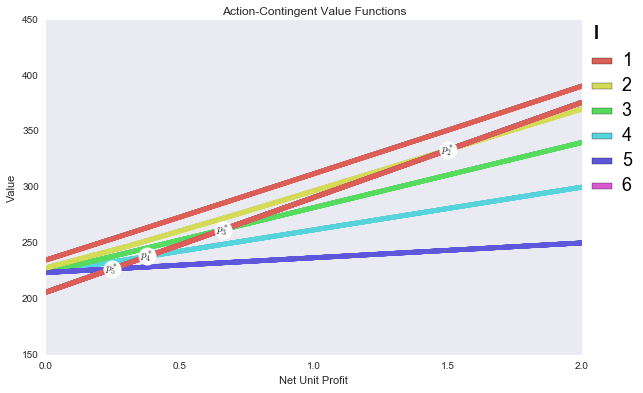

In [10]:
fig = demo.qplot('unit profit', 'value_j', 'i',
                 data=S,
                 main='Action-Contingent Value Functions',
                 xlab='Net Unit Profit',
                 ylab='Value')

ni, nj = model.dims['ni', 'nj']
vr = S['value_j'].reshape(ni, nj, -1)
pr = S['unit profit'].reshape(ni, nj, -1)[0, 0]
fig.draw()

print('Critical Replacement Profit\n')
for a in range(A-1):
    pcrit = np.interp(0.0, vr[a, 1] - vr[a, 0], pr, np.nan, np.nan)
    vcrit = np.interp(pcrit, pr, vr[a, 0])
    if np.isnan(pcrit):
        continue

    demo.annotate(pcrit, vcrit, '$p^*_' + str(a+1) + '$', 'wo',
                  (0, 0), fs=11, ms=18)
    print('   Age {:2d}  Profit {:5.2f}'.format(a, pcrit))

plt.xlim(pmin,pmax)
plt.show()

### Compute and Plot Critical Unit Profit Contributions


### Plot Residual

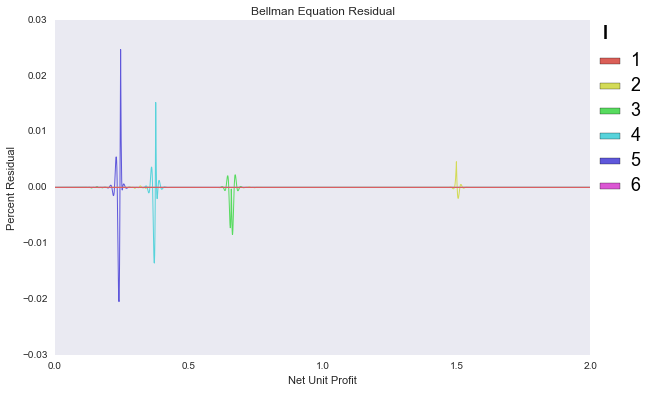

<ggplot: (163843090040)>

In [11]:
S['resid2'] = 100*S.resid / S.value
demo.qplot('unit profit', 'resid2','i',
           data=S,
           geom='line',
           main='Bellman Equation Residual',
           xlab='Net Unit Profit',
           ylab='Percent Residual')

### SIMULATION

In [12]:
T = 50
nrep = 10000
sinit = np.full(nrep, pbar)
iinit = 0
data = model.simulate(T,sinit,iinit, seed=945)

### Print Ergodic Moments

In [13]:
frm = '\t{:<10s} = {:5.2f}'

print('\nErgodic Means')
print(frm.format('Price', data['unit profit'].mean()))
print(frm.format('Age', data.i.mean()))
print('\nErgodic Standard Deviations')
print(frm.format('Price', data['unit profit'].std()))
print(frm.format('Age', data.i.std()))


Ergodic Means
	Price      =  1.00
	Age        =  2.01

Ergodic Standard Deviations
	Price      =  0.17
	Age        =  0.83


### Plot Simulated and Expected Continuous State Path

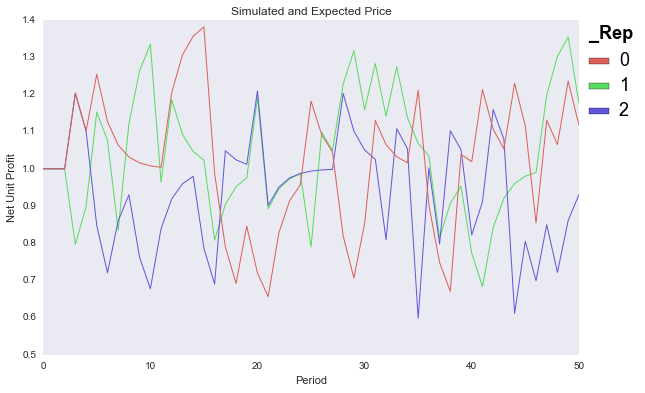

<ggplot: (-9223371873012094839)>

In [14]:
demo.qplot('time', 'unit profit', '_rep',
           data=data[data['_rep'] < 3],
           geom='line',
           main='Simulated and Expected Price',
           ylab='Net Unit Profit',
           xlab='Period')

### Plot Expected Discrete State Path

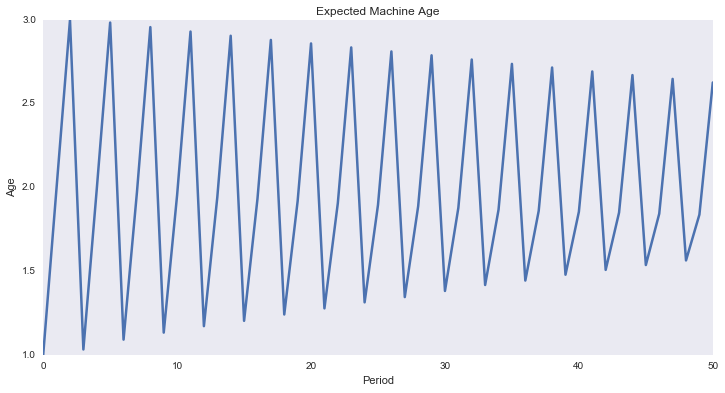

In [15]:
data[['time', 'i']].groupby('time').mean().plot(legend=False)
plt.title('Expected Machine Age')
plt.xlabel('Period')
plt.ylabel('Age')